# PointNet Layer

PointNet++ processes point clouds iteratively by following a simple grouping, neighborhood aggregation and downsampling scheme:

1. The **grouping phase** constructs a graph in which nearby points are connected. Typically, this is either done via  $k$-nearest neighbor search or via ball queries (which connects all points that are within a radius to the query point).

2. The **neighborhood aggregation phase** executes a Graph Neural Network layer that, for each point, aggregates information from its direct neighbors (given by the graph constructed in the previous phase).
This allows PointNet++  to capture local context at different scales.

3. The **downsampling phase** implements a pooling scheme suitable for point clouds with potentially different sizes. We will ignore this phase for now and will come back later to it.

https://arxiv.org/pdf/1609.02907

## Importing Necessary Libraries

In [1]:
import torch
from torch_geometric.transforms import SamplePoints
from torch_cluster import knn_graph
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.nn import global_max_pool
from torch_geometric.datasets import GeometricShapes
import random
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose, RandomRotate

In [2]:
def visualize_mesh(pos, face):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=face.t(), antialiased=False)
    plt.show()

In [3]:
def data_details(dataset):
    print()
    print(f'Dataset: {dataset}:')
    print('====================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')


## Import Dataset

In [4]:
from torch_geometric.datasets import GeometricShapes

dataset = GeometricShapes(root='data/GeometricShapes')
print(dataset)

GeometricShapes(40)


Data(pos=[225, 3], face=[3, 416], y=[1])


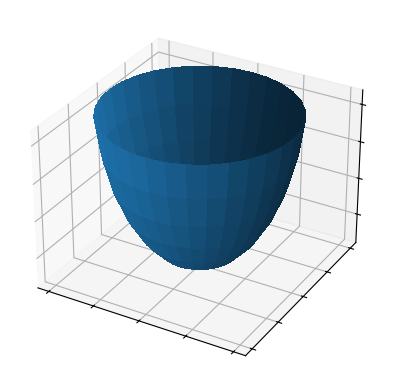

In [5]:
data = dataset[25]
print(data)
visualize_mesh(data.pos, data.face)

/mnt/f/Rohan/Ubuntu_2204/virtual_env/venv_pytorch/lib/python3.10/site-packages/torch_geometric/transforms/sample_points.py:40: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:63.)
  area = (pos[face[1]] - pos[face[0]]).cross(pos[face[2]] - pos[face[0]])


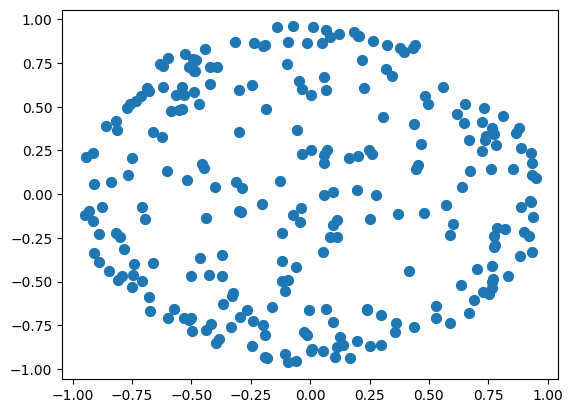

In [6]:
torch.manual_seed(42)
dataset.transform = SamplePoints(num=256)

n = 20
data = dataset[20]
plt.scatter(data.pos[:, 0], data.pos[:, 1], s=50, zorder=1000)

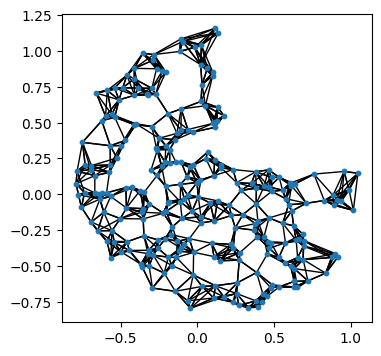

In [7]:
import numpy as np
n = 3
data = dataset[n]
data.edge_index = knn_graph(data.pos, k=6)
fig = plt.figure(figsize=(4, 4))
for (x,y) in data.edge_index.t().tolist():
    src = data.pos[x].tolist()
    dst = data.pos[y].tolist()
    plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
plt.scatter(data.pos[:, 0], data.pos[:, 1], s=10, zorder=1000)

In [8]:
data_details(dataset)


Dataset: GeometricShapes(40):
Number of graphs: 40
Number of features: 0
Number of classes: 40


In [9]:
class PointNetLayer(MessagePassing):

    def __init__(self,in_channels,out_channels):

        super().__init__(aggr = 'max')
        self.mlp = Sequential(Linear(in_channels + 3, out_channels),
                              ReLU(),
                              Linear(out_channels, out_channels))

    def forward(self,h,pos,edge_index):
        return self.propagate(edge_index,h=h,pos=pos)

    def message(self,h_j,pos_j,pos_i):
        input_rel_pos = pos_j - pos_i
        if h_j is not None:
            input = torch.cat([h_j, input_rel_pos], dim=-1)
        return self.mlp(input)

In [10]:
class PointNet(torch.nn.Module):

    def __init__(self):

        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = PointNetLayer(3, 32)
        self.conv2 = PointNetLayer(32, 32)
        self.classifier = Linear(32, dataset.num_classes)

    def forward(self,pos,batch):
        edge_index = knn_graph(pos, k=16, batch=batch, loop=True)
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = global_max_pool(h, batch)

        return self.classifier(h)
    

In [11]:
model = PointNet()

In [12]:
print(f"Model Summary for {model.__class__.__name__}")
print("-" * 60)
    
total_params = 0
for name, layer in model.named_children():
    print(name)
    print(layer)

Model Summary for PointNet
------------------------------------------------------------
conv1
PointNetLayer()
conv2
PointNetLayer()
classifier
Linear(in_features=32, out_features=40, bias=True)


In [13]:
point_sampled = 500
train_dataset = GeometricShapes(root='data/GeometricShapes', train=True,
                                transform=SamplePoints(point_sampled))
test_dataset = GeometricShapes(root='data/GeometricShapes', train=False,
                               transform=SamplePoints(point_sampled))

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10)

GeometricShapes(40)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointNet()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
loss_crit = torch.nn.CrossEntropyLoss()

def train(model,optimizer,loader):

    model.train()
    total_loss = 0

    for data in loader:
        optimizer.zero_grad()  # Clear gradients.
        data = data.to(device)
        logits = model(data.pos, data.batch)  # Forward pass.
        loss = loss_crit(logits, data.y)  # Loss computation.
        loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.
        total_loss += loss.item() * data.num_graphs

    return total_loss/len(loader.dataset)

@torch.no_grad()
def test(model, loader):
    model.eval()

    total_correct = 0
    for data in loader:
        data = data.to(device)
        logits = model(data.pos, data.batch)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())

    return total_correct / len(loader.dataset)

for epoch in range(1, 150):
    loss = train(model.to(device), optimizer, train_loader)
    test_acc = test(model.to(device), test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

/mnt/f/Rohan/Ubuntu_2204/virtual_env/venv_pytorch/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 01, Loss: 3.7482, Test Accuracy: 0.0500
Epoch: 02, Loss: 3.7049, Test Accuracy: 0.0500
Epoch: 03, Loss: 3.6938, Test Accuracy: 0.0500
Epoch: 04, Loss: 3.6842, Test Accuracy: 0.0250
Epoch: 05, Loss: 3.6676, Test Accuracy: 0.0250
Epoch: 06, Loss: 3.6289, Test Accuracy: 0.0250
Epoch: 07, Loss: 3.5804, Test Accuracy: 0.0250
Epoch: 08, Loss: 3.5122, Test Accuracy: 0.0750
Epoch: 09, Loss: 3.4350, Test Accuracy: 0.0750
Epoch: 10, Loss: 3.3295, Test Accuracy: 0.0750
Epoch: 11, Loss: 3.2229, Test Accuracy: 0.1000
Epoch: 12, Loss: 3.1250, Test Accuracy: 0.1000
Epoch: 13, Loss: 2.9991, Test Accuracy: 0.1500
Epoch: 14, Loss: 2.8178, Test Accuracy: 0.1750
Epoch: 15, Loss: 2.6441, Test Accuracy: 0.3250
Epoch: 16, Loss: 2.4499, Test Accuracy: 0.3500
Epoch: 17, Loss: 2.2504, Test Accuracy: 0.5250
Epoch: 18, Loss: 2.0602, Test Accuracy: 0.3250
Epoch: 19, Loss: 1.9889, Test Accuracy: 0.3500
Epoch: 20, Loss: 1.9222, Test Accuracy: 0.5000
Epoch: 21, Loss: 1.6958, Test Accuracy: 0.5250
Epoch: 22, Lo

In [25]:
from torch_geometric.nn import PPFConv
from torch_cluster import fps
from torch_geometric.nn import MLP

class PPFNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        torch.manual_seed(12345)
        mlp1 = MLP([4,32])  # TODO
        self.conv1 = PPFConv(local_nn = mlp1,add_self_loops=False)  # TODO
        mlp2 = MLP([32+4,32])
        self.conv2 = PPFConv(local_nn = mlp2,add_self_loops=False)  # TODO
        self.classifier = Linear(32, dataset.num_classes)

    def forward(self, pos, normal, batch):
        edge_index = knn_graph(pos, k=16, batch=batch, loop=False)

        x = self.conv1(x=None, pos=pos, normal=normal, edge_index=edge_index)
        x = x.relu()
        print(x.size())
        x = self.conv2(x=x, pos=pos, normal=normal, edge_index=edge_index)
        x = x.relu()

        x = global_max_pool(x, batch)  # [num_examples, hidden_channels]
        return self.classifier(x)


model = PPFNet()
print(model)

PPFNet(
  (conv1): PPFConv(local_nn=MLP(4, 32), global_nn=None)
  (conv2): PPFConv(local_nn=MLP(36, 32), global_nn=None)
  (classifier): Linear(in_features=32, out_features=40, bias=True)
)


In [16]:
random_rotate = Compose([
    RandomRotate(degrees=180, axis=0),
    RandomRotate(degrees=180, axis=1),
    RandomRotate(degrees=180, axis=2),
])

In [21]:
for data in train_loader:
    print(data)

DataBatch(pos=[1280, 3], y=[10], normal=[1280, 3], batch=[1280], ptr=[11])
DataBatch(pos=[1280, 3], y=[10], normal=[1280, 3], batch=[1280], ptr=[11])
DataBatch(pos=[1280, 3], y=[10], normal=[1280, 3], batch=[1280], ptr=[11])
DataBatch(pos=[1280, 3], y=[10], normal=[1280, 3], batch=[1280], ptr=[11])


In [ ]:
test_transform = Compose([
    random_rotate,
    SamplePoints(num=128, include_normals=True),
])

train_dataset = GeometricShapes(root='data/GeometricShapes', train=False,
                               transform=SamplePoints(128, include_normals=True))
test_dataset = GeometricShapes(root='data/GeometricShapes', train=False,
                               transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10)

model = PPFNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.

def train(model, optimizer, loader):
    model.train()

    total_loss = 0
    for data in loader:
        optimizer.zero_grad()  # Clear gradients.
        logits = model(data.pos, data.normal, data.batch)
        loss = criterion(logits, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(model, loader):
    model.eval()

    total_correct = 0
    for data in loader:
        logits = model(data.pos, data.normal, data.batch)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())

    return total_correct / len(loader.dataset)

for epoch in range(1, 101):
    loss = train(model, optimizer, train_loader)
    test_acc = test(model, test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
Epoch: 01, Loss: 3.9134, Test Accuracy: 0.0250
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
Epoch: 02, Loss: 3.7103, Test Accuracy: 0.0250
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
Epoch: 03, Loss: 3.6538, Test Accuracy: 0.0250
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
Epoch: 04, Loss: 3.6123, Test Accuracy: 0.0500
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.Size([1280, 32])
torch.S